In [1]:
import numpy as np
from random import randint
from matplotlib import pyplot as plt
from tqdm import tqdm
from linearization import *
from matplotlib import animation
from mpl_toolkits import mplot3d
import cvxopt
import cvxpy as cp
from scipy.linalg import sqrtm
import sympy as sp

%matplotlib inline

Plot vectorfield of replicator dynamics for discretization n=2.
In the case n=2, the vectorfield points into the "correct" direction and it shouldn't be too hard to prove convergence.

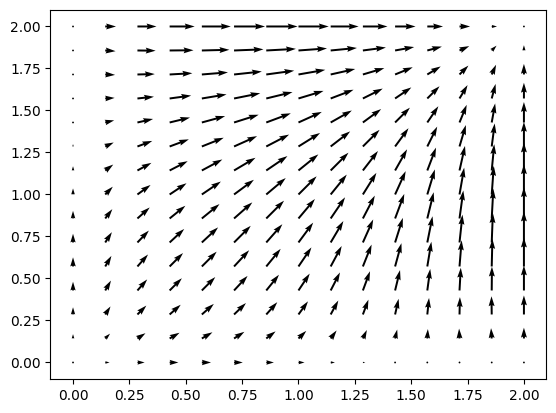

In [8]:
psicalc = PsiCalculator(n=2)
X = []
Y = []
U = []
V = []
for f1 in np.linspace(0,2.,15):
    for g1 in np.linspace(0.,2.,15):
        Psi = psicalc.computeReducedAt(np.array([[f1]]), np.array([[g1]]))
        U.append(Psi['Psif'][0])
        V.append(Psi['Psig'][0])
        X.append(f1)
        Y.append(g1)
plt.quiver(X,Y,U,V)
plt.show()

Animation of the replicator dynamics (with forward euler)

KeyboardInterrupt: 

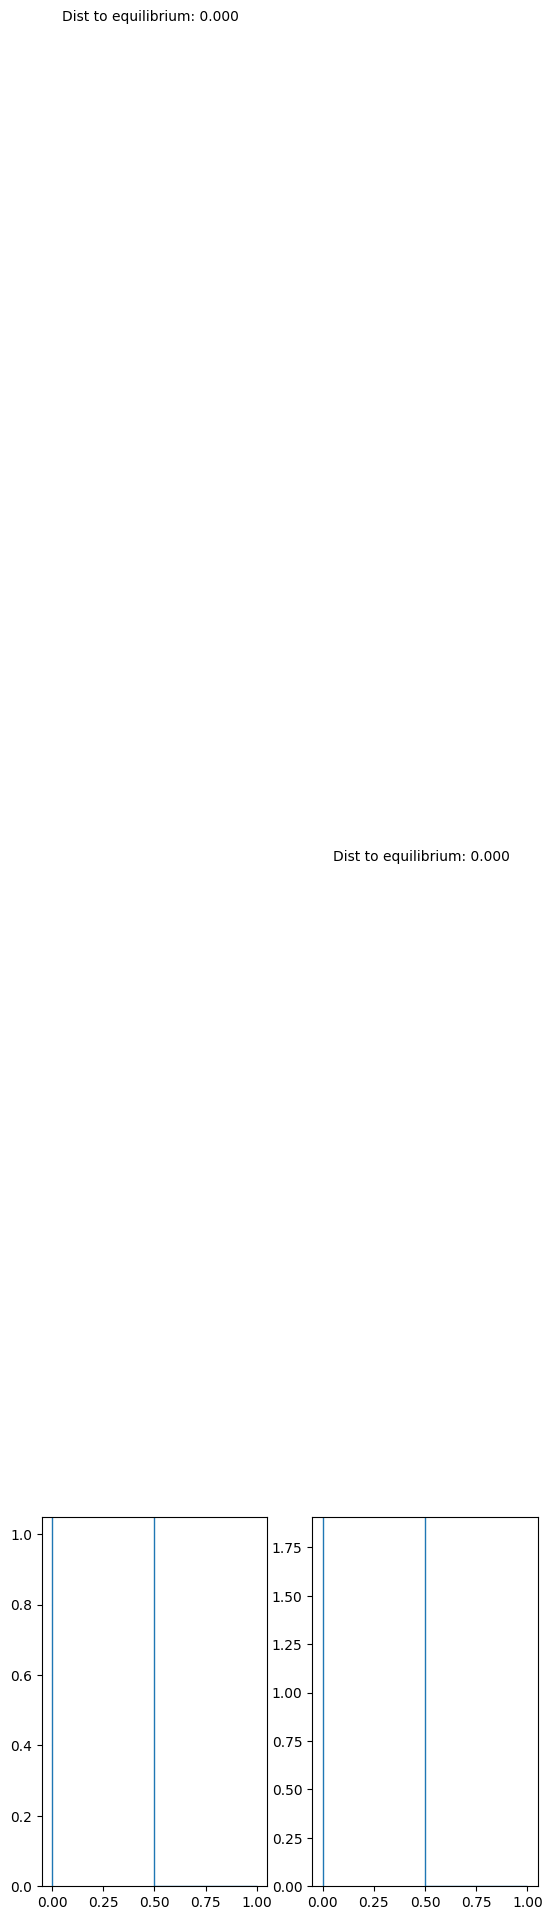

In [11]:
n = 10
n_frames = 2500
# Computing a frame seems to take relatively long,
# so do multiple iterations before showing the next frame
iterations_per_frame = 4


h = 0.1


psicalc = PsiCalculator(n)

equilibrium = np.zeros((n,1))
for i in range(int(n/2)):
    equilibrium[i,0] = 1.
equilibrium = equilibrium * n/equilibrium.sum()

f = 0.1 * np.ones((n,1))
f[4:5,0] = np.ones((1,))
f = f * n/f.sum()
g = 0.1 * np.ones((n,1))
g[0:1,0] = np.ones((1,))
g = g * n/g.sum()

fig = plt.figure()
[ax1, ax2] = fig.subplots(nrows = 1, ncols = 2)
dist1_text = ax1.text(0.05,5.3,"Dist to equilibrium: %.3f" % (np.sqrt(1./n)*np.linalg.norm(f-equilibrium)))
line1 = ax1.stairs(values=f.flatten(), edges=np.linspace(start = 0.,stop = 1., num=n+1))
dist2_text = ax2.text(0.05,5.3,"Dist to equilibrium: %.3f" % (np.sqrt(1./n)*np.linalg.norm(g-equilibrium)))
line2 = ax2.stairs(values=g.flatten(), edges=np.linspace(start = 0.,stop = 1., num=n+1))

def drawframe(it):
    for _ in range(iterations_per_frame):
        Psi = psicalc.computeAt(f,g)
        f[:,0] += h*Psi['Psif']
        g[:,0] += h*Psi['Psig']
    line1.set_data(values=f.flatten(), edges=np.linspace(start = 0.,stop = 1., num=n+1))
    dist1_text.set_text("Dist to equilibrium: %.3f" % (np.sqrt(1./n)*np.linalg.norm(f-equilibrium)))
    line2.set_data(values=g.flatten(), edges=np.linspace(start = 0.,stop = 1., num=n+1))
    dist2_text.set_text("Dist to equilibrium: %.3f" % (np.sqrt(1./n)*np.linalg.norm(g-equilibrium)))
    return (line1,line2,dist1_text,dist2_text)

anim = animation.FuncAnimation(fig, drawframe, frames = n_frames, interval=10, blit=True)
from IPython.display import HTML
HTML(anim.to_html5_video())

STRONG UNINAVOIDABILITY

Motivation:

A profile (x*,y*) is a strong uninvadable profile, if u(x*,y) > u(x,y) for all x,y in a neighbourhood of (x*,y*) for all players. (see e.g. Mendoza-Palacios 2015)

This property guarantees local stability. However, it does not hold for our game. However, we can explore, how "strong" it is violated.

Approach:
- Let (f*,g*) be the Bayes Nash equilibrium.
- Let Delta be a random strategy and set g = (1-lambda)g* + (1-lambda)Delta with lambda relatively small
- Compute the best response f against g in a neighbourhood of f* (this is a QCQP)
- Compute the utility difference u(f*,g)-u(f,g)

If the game were to satisfy the strong uninvadability property, the loss would always be 0. Since this is not the case for our game, we may at least hope that the loss is small.

Text(0, 0.5, 'u(f*,g)-u(f,g)')

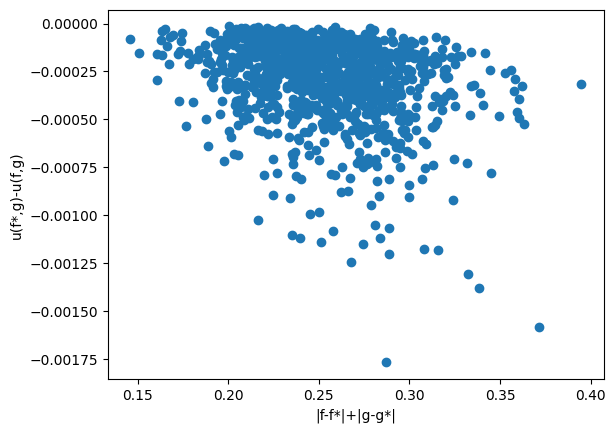

In [18]:

n = 16

f_equil = np.zeros((n,))
for i in range(int(n/2)):
    f_equil[i] = 1
f_equil = n * f_equil / np.sum(f_equil)
g_equil = np.zeros((n,))
for i in range(int(n/2)):
    g_equil[i] = 1
g_equil = n * g_equil / np.sum(g_equil)

n_samples = 1000
utility_loss = []
rel_utility_loss = []
distances = []
for _ in range(n_samples):
    g = 0.9*g_equil + 0.1*random_density(n)
    dist_g = L2norm(g-g_equil)
    br = best_response_in_neighbourhood(f_equil, g, dist_g)
    distances.append(dist_g + L2norm(f_equil - br['strategy']))
    utility_loss.append(-(br['utility'] - compute_utility(n,f_equil,g)))
    rel_utility_loss.append(-(br['utility'] - compute_utility(n,f_equil,g))/compute_utility(n,f_equil,g))


plt.scatter(distances, rel_utility_loss)
plt.xlabel("|f-f*|+|g-g*|")
plt.ylabel("u(f*,g)-u(f,g)")


If we do not compute the best response f against f*, but sample both g and f randomly in a neighbourhood of (f*,g*), the strong uniavoidability property seems to be satisfied.

Here we sample random densities (Deltaf,Deltag) and compute the losses
u(f*,g) - u(f,g)
for f = (1-lambda)f* + lambda f and g = (1-lambda)g* + lambda g
for several values lambda

Here, it turns out that when sampled randomly, the experiments only yield positive utility differences, telling us that f* is a better response to g than f.


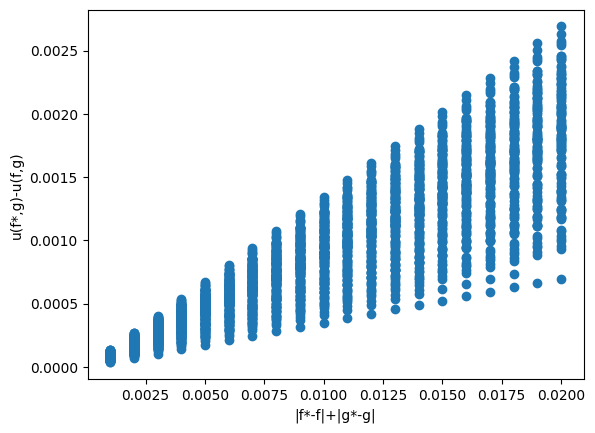

In [17]:
n = 20

f_equil = np.zeros((n,))
for i in range(int(n/2)):
    f_equil[i] = 2
F_equil = np.cumsum(f_equil)/n
g_equil = np.zeros((n,))
for i in range(int(n/2)):
    g_equil[i] = 2
G_equil = np.cumsum(g_equil)/n
g_truthful = np.ones((n,))


distance_to_equil = []
utility_diff = []

n_samples = 200
min_dist = 0.001
max_dist = 0.02
n_dists = 20


fig = plt.figure()
ax = fig.subplots(1,1)


for _ in range(n_samples):
    f = random_density(n)
    deltaf = (f - f_equil)/L2norm(f-f_equil)
    F = np.cumsum(f)/n
    deltaF = (f-f_equil)/L2norm(F-F_equil)
    g = random_density(n)
    deltag = (g-g_equil)/L2norm(g-g_equil)
    G = np.cumsum(g)/n
    deltaG = (g-g_equil)/L2norm(G-G_equil)
    for a in np.linspace(min_dist,max_dist,n_dists):
        if np.min(f + a*deltaf) < 0 or np.min(g + a*deltag) < 0:
            break
        distance_to_equil.append(a)
        utility_diff.append(compute_utility(n,f_equil,g_equil+a*deltag) - compute_utility(n,f_equil+a*deltaf,g_equil+a*deltag))
        #ax.plot(a, compute_utility(n,f_equil,g_equil+a*deltag) - compute_utility(n,f_equil+a*deltaf,g_equil+a*deltag))
plt.scatter(distance_to_equil, utility_diff)
plt.xlabel("|f*-f|+|g*-g|")
plt.ylabel("u(f*,g)-u(f,g)")
plt.show()

[0.0, 0.03000485908649175, 0.04956268221574346, 0.06013119533527699, 0.06316812439261422, 0.060131195335277006, 0.052478134110787215, 0.041666666666666706, 0.02915451895043736, 0.016399416909621038, 0.004859086491739598, -0.004008746355685104, -0.008746355685131175, -0.007896015549076768, -6.503898174780929e-260, 0.0, 0.03316326530612246, 0.05539358600583092, 0.06814868804664725, 0.07288629737609333, 0.071064139941691, 0.06413994169096214, 0.05357142857142861, 0.04081632653061228, 0.02733236151603503, 0.014577259475218703, 0.004008746355685156, -0.0029154518950437118, -0.004737609329446057, -6.351463061309501e-263, 0.0, 0.03632167152575316, 0.06122448979591838, 0.07616618075801751, 0.08260447035957243, 0.08199708454810499, 0.07580174927113706, 0.06547619047619051, 0.05247813411078721, 0.03826530612244902, 0.024295432458697808, 0.012026239067055418, 0.0029154518950437517, -0.0015792031098153447, -7.753250807262575e-267, 0.0, 0.039480077745383875, 0.06705539358600585, 0.08418367346938778

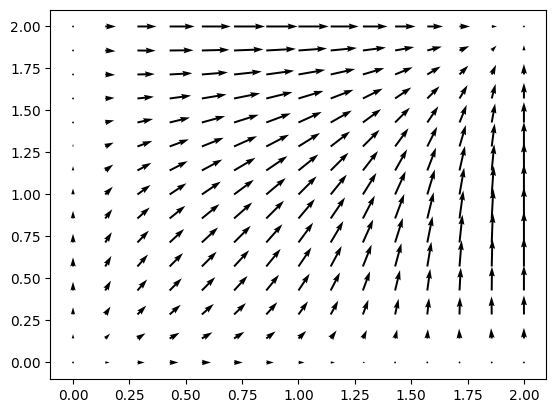

In [25]:
### Test if symbolic polynomials work
n = 2
psicalc = PsiCalculator(2)
f = sp.symarray('f', shape=(1,1))
g = sp.symarray('g', shape=(1,1))
Psi = psicalc.computeReducedAt(f,g)


X = []
Y = []
U = []
V = []
for f1 in np.linspace(0,2.,15):
    for g1 in np.linspace(0.,2.,15):
        U.append(float(Psi['Psif'][0].evalf(subs={f[0,0]:f1, g[0,0]:g1})))
        V.append(float(Psi['Psig'][0].evalf(subs={f[0,0]:f1, g[0,0]:g1})))
        X.append(f1)
        Y.append(g1)
print(V)
print(U)
print(X)
print(Y)
plt.quiver(X,Y,U,V)
plt.show()

We are looking for a Lyapunov function L such that
- L(f,g) >= 0 for all feasible strategies
- <DL(f,g), Phi(f,g)> < 0 with equality iff (f,g)=(f*,g*)

The set S of feasible strategies f is given by the constraints
- f_i >= 0
- sum_i f_i <= n

Let m be the minimum value of the polynomial
    H(f) = sum_i f_i(f_i - n) + (sum_i f_i)(sum_i f_i - n)

In [78]:
from sympy.polys.monomials import itermonomials
import SumOfSquares as sos
from functools import reduce

n = 2
lyap_max_deg = 4 # maximum degree of lyapunov function

epsilon = 0.0001
assert(n%2 == 0)

prob = sos.SOSProblem()


equil = np.zeros((n-1,1))
for i in range(int(n/2)):
    equil[i,0] = 2


psicalc = PsiCalculator(n)
f = sp.symarray('f', shape=(n-1,1))
g = sp.symarray('g', shape=(n-1,1))
variables = f.flatten().tolist()+g.flatten().tolist()
Psi = psicalc.computeReducedAt(f,g)

monomials = np.array(list(itermonomials(variables, max_degrees=lyap_max_deg)))
lyap_coefficients = sp.symarray('l', shape=monomials.shape)
lyap_fct = lyap_coefficients @ monomials 
sq_dist_equil = (np.sum((f-equil)**2))
# positivity of lyapunov function
prob.add_sos_constraint(lyap_fct - epsilon*sq_dist_equil, variables)

## Derivative of Lyapunov function
d_lyap_f = np.array([sp.diff(lyap_fct, df) for df in f.flatten()])
d_lyap_g = np.array([sp.diff(lyap_fct, dg) for dg in g.flatten()])
inner_prod = Psi['Psif'].T @ d_lyap_f + Psi['Psig'].T @ d_lyap_g
# negativity of derivative
print(inner_prod)
prob.add_sos_constraint(-inner_prod, variables)


lyap_coeff_vars = [prob.sym_to_var(c) for c in lyap_coefficients]
prob.solve()

coeff_values = [c.value for c in lyap_coeff_vars]
print(lyap_fct.evalf(subs=dict(zip(lyap_coefficients,coeff_values))))


(-1.0*f_0_0**2*(0.0208333333333333*f_0_0*g_0_0 - 0.0416666666666667*g_0_0) - 1.0*f_0_0*(2 - f_0_0)*(0.125*f_0_0 - 0.0833333333333333*g_0_0 + (0.0416666666666667 - 0.0208333333333333*g_0_0)*(2 - f_0_0) - 0.208333333333333) + 2*f_0_0*(0.0208333333333333*f_0_0*g_0_0 - 0.0416666666666667*g_0_0))*(4*f_0_0**3*l_6 + 3*f_0_0**2*g_0_0*l_14 + 3*f_0_0**2*l_13 + 2*f_0_0*g_0_0**2*l_12 + 2*f_0_0*g_0_0*l_4 + 2*f_0_0*l_2 + g_0_0**3*l_3 + g_0_0**2*l_8 + g_0_0*l_10 + l_7) + (-1.0*g_0_0**2*(0.0208333333333333*f_0_0*g_0_0 - 0.0416666666666667*f_0_0) - 1.0*g_0_0*(2 - g_0_0)*(-0.0833333333333333*f_0_0 + 0.125*g_0_0 + (0.0416666666666667 - 0.0208333333333333*f_0_0)*(2 - g_0_0) - 0.208333333333333) + 2*g_0_0*(0.0208333333333333*f_0_0*g_0_0 - 0.0416666666666667*f_0_0))*(f_0_0**3*l_14 + 2*f_0_0**2*g_0_0*l_12 + f_0_0**2*l_4 + 3*f_0_0*g_0_0**2*l_3 + 2*f_0_0*g_0_0*l_8 + f_0_0*l_10 + 4*g_0_0**3*l_0 + 3*g_0_0**2*l_5 + 2*g_0_0*l_9 + l_11)


ArithmeticError: 5

Algorithm:
-   set g_i(f) = f_i for i=1,...,n-1 and g_n(f) = n - sum_i f_i.
    then {g_i(f) >= 0} is the feasible region
-   Parametrize polynomials sigma_0, sigma_1, ..., sigma_{n-1}, sigma_n
    and set V = sigma_0 + sum_{i=1}^{n} sigma_i g_i
    -   Add the constraint that sigma_i is SOS for all i=0,...,n
-   Parametrize polynomials chi_0,...,chi_n
    -   Add the constraint that all chi_i are SOS
    -   Add the constraint that -<grad V, Psi> = chi_0 + sum_i chi_i g_i
- Parametrize V_i = {g_i(f) = 0} = {\sum_{j != i lambda_j f_j}} for i=1,...,n-1
- For 


In [91]:
from sympy.polys.monomials import itermonomials
import SumOfSquares as sos
from functools import reduce
from lyapunov_utils import *

max_degree = 4
n = 2

f = sp.symarray((n-1,))
g = sp.symarray((n-1,))
equil = np.zeros((n,))
for i in range(int(n/2)):
    equil[i] = 2

def get_constraints(reduced_strategy):
    constraints = [reduced_strategy[i]-equil[i] for i in range(int(n/2))] +\
                [reduced_strategy[i] for i in range(int(n/2),n-1)] +\
                [-np.sum(reduced_strategy)]
    H   = [ [reduced_strategy[j].subs([(reduced_strategy[i], equil[i])]) for j in range(n-1)] for i in range(n-1) ] +\
    [ [reduced_strategy[j] for j in range(n-2)] + [-np.sum(reduced_strategy[:-1])] ]
    return constraints, H

def to_centered_and_reduced(f):
    # returns reduced f-equil
    return (f + equil)[:-1]

def from_centered_reduced(f):
    uncentered_reduced = f - equil[:-1]
    return np.concatenate([f,[n - np.sum(f)]])

problem = sos.SOSProblem()



f = sp.symarray('f', shape=(n-1,1))
g = sp.symarray('g', shape=(n-1,1))
variables = f.flatten().tolist()+g.flatten().tolist()
constraints_f, H_g = get_constraints(f)
constraints_g, H_g = get_constraints(g)
constraints = constraints_f + constraints_g
num_constraints = len(constraints)

Vpolys, Vparams = generate_parametrized_polynomials(
    num_constraints + 1,
    monomials = np.array(list(itermonomials(variables, max_degrees=max_degree))),
    parameter_prefix = 'sigma'
)

# Add constraint functions such that feasible region is {c_i >= for all i}
sigma_monomials = np.array(list(itermonomials(variables, max_degrees=max_deg_sigma)))
c = f.flatten().tolist() +\
    g.flatten().tolist() +\
    [n - reduce(lambda a, b: a+b, f.flatten().tolist())] +\
    [n - reduce(lambda a, b: a+b, g.flatten().tolist())]
assert(len(c) == 2*n)

# write V as SOS linear combination of the constraints
sigma_coefficients = sp.symarray('sigma', (1+len(c), np.size(sigma_monomials)))
sigma = [sigma_coefficients[i,:] @ sigma_monomials for i in range(n+1)]
V = sigma[0] + reduce(lambda a,b: a+b,[ci*si for (ci,si) in zip(c,sigma)])
for si in sigma:
    problem.add_sos_constraint(si, variables)

# gradient of V
nabla_V_f = [sp.diff(V, f[i,0]) for i in range(n-1)]
nabla_V_g = [sp.diff(V, g[i,0]) for i in range(n-1)]
# Utility
f_unreduced = np.concatenate([f, [[n-np.sum(f)]]])
g_unreduced = np.concatenate([g, [[n-np.sum(g)]]])
utility_agent_1 = compute_utility(n, f_unreduced, g_unreduced)[0]
nabla_u1 = [sp.diff(utility_agent_1, f[i,0]) for i in range(n-1)]
utility_agent_2 = compute_utility(n, g_unreduced, f_unreduced)[0]
nabla_u2 = [sp.diff(utility_agent_2, g[i,0]) for i in range(n-1)]
# -<nabla V, nabla_u>
neg_nablaV_nablaU = np.inner(nabla_V_f, nabla_u1) + np.inner(nabla_V_g, nabla_u2)

# write -<nabla_V, Psi> as a SOS linear combination of constraints
max_deg_chi = sp.Poly(neg_nablaV_nablaU, *variables).total_degree()
chi_monomials = np.array(list(itermonomials(variables, max_degrees=max_deg_chi)))
chi_coefficients = sp.symarray('chi', (1+len(c), np.size(chi_monomials)))
chi = [chi_coefficients[i,:] @ chi_monomials for i in range(n+1)]
chi_combination = chi[0] + np.sum([x*y for (x,y) in zip(chi,c)])
for x in chi:
    problem.add_sos_constraint(x, variables)
# chi_combination must be equal to neg_nablaV_nablaU
add_poly_equality_constraint(
    problem,
    sp.Poly(neg_nablaV_nablaU - chi_combination, *variables)
)

#for coeff in diff_chi_nabla.coeffs():
#    print(coeff)



In [2]:
from lyapunov_utils import *
import SumOfSquares as sos
from sympy.polys.monomials import itermonomials



x1, x2 = sp.symbols('x1 x2')
max_degree = 4

problem = sos.SOSProblem()

variables = [x1, x2]
n = len(variables)

f = [-x1**2, 0]

g1 = x1 - x2**2
H1 = [x2**2, x2]

g2 = 1 - x1
H2 = [1, x2]

constraints = [g1, g2]

monomials = list(itermonomials(variables, max_degrees=max_degree))

add_lyapunov_constraints(
    problem=problem,
    max_degree=max_degree,
    variables=variables,
    f=f,
    constraints=constraints,
    H = [H1,H2]
)

problem.solve()


ValueError: shapes (3,) and (1,3) not aligned: 3 (dim 0) != 1 (dim 0)

-1.13117613707687*f0**3 + 0.763466677703103*f0**2*g0 + 6.85719598207148*f0**2 + 0.763466676920493*f0*g0**2 - 1.44133599481053*f0*g0 + 2.32970087665763e-10*f0 - 1.13117613642304*g0**3 + 6.85719599522949*g0**2 + 2.32969865621158e-10*g0 + 5.61209557321631


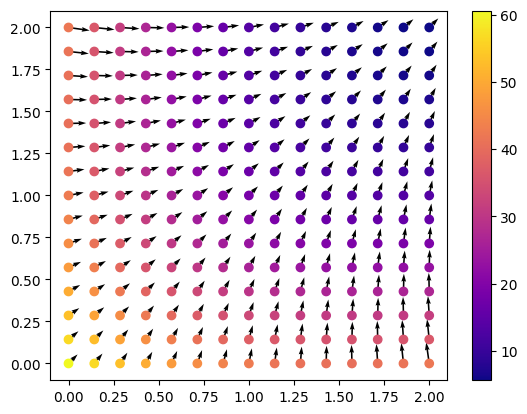

In [10]:
file = open('../lyapunov_n=2_deg=2.txt')
f0, g0 = sp.symbols('f0 g0')
lyapunov_function = sp.sympify(file.read(), locals={'f_0':f0, 'g_0':g0})
print(lyapunov_function)
file.close()

f = np.array([[f0],[2-f0]])
g = np.array([[g0],[2-g0]])

utility_f = compute_utility(2, f, g)[0]
utility_g = compute_utility(2, g, f)[0]

vectorfield = [utility_f.diff(f0), utility_g.diff(g0)]

X = []
Y = []
U = []
V = []
lyapunov_values = []
for fval in np.linspace(0,2.,15):
    for gval in np.linspace(0.,2.,15):
        subs = {f0:fval, g0:gval}
        U.append(float(vectorfield[0].evalf(subs=subs)))
        V.append(float(vectorfield[1].evalf(subs=subs)))
        X.append(fval)
        Y.append(gval)
        lyapunov_values.append(float(lyapunov_function.evalf(subs={f0:fval-2,g0:gval-2})))
plt.quiver(X,Y,U,V)
sc = plt.scatter(X,Y,c=lyapunov_values, cmap='plasma')
plt.colorbar(sc)
plt.show()



-1.13117613707687*f0**3 + 0.763466677703103*f0**2*g0 + 6.85719598207148*f0**2 + 0.763466676920493*f0*g0**2 - 1.44133599481053*f0*g0 + 2.32970087665763e-10*f0 - 1.13117613642304*g0**3 + 6.85719599522949*g0**2 + 2.32969865621158e-10*g0 + 5.61209557321631
[13.3758946022611, 13.3440477288977, 13.3122984061589, 13.2806466262928, 13.2490923787591, 13.2176356502479, 13.1862764246986, 13.1550146833186, 13.1238504046022, 13.0927835643494, 13.0618141356852, 13.0309420890781, 13.0001673923598, 12.9694900107441, 12.9389099068459, 12.9084270407008, 12.8780413697839, 12.8477528490296, 12.8175614308508, 12.7874670651581, 12.7574696993794, 12.7275692784792, 12.6977657449783, 12.6680590389732, 12.6384490981556, 12.6089358578317, 12.5795192509423, 12.5501992080819, 12.5209756575186, 12.4918485252135, 12.4628177348404, 12.4338832078054, 12.4050448632665, 12.3763026181533, 12.3476563871866, 12.3191060828981, 12.2906516156497, 12.2622928936535, 12.2340298229914, 12.2058623076343, 12.1777902494622, 12.14981

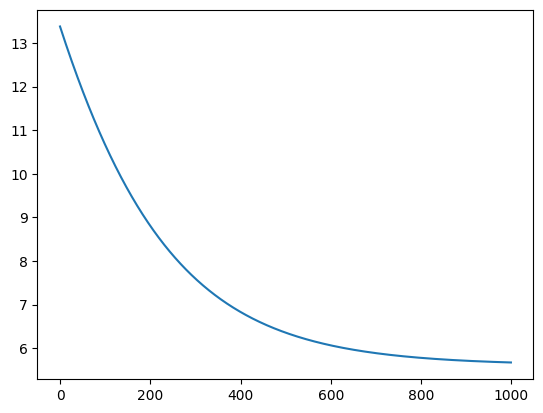

In [22]:
n = 2
num_iterations = 1000

file = open(f'../lyapunov_n={2}_deg=2.txt')
f0, g0 = sp.symbols('f0 g0')
lyapunov_function = sp.sympify(file.read(), locals={'f_0':f0, 'g_0':g0})
print(lyapunov_function)
file.close()

h = 0.01


psicalc = PsiCalculator(n)

equilibrium = np.zeros((n,1))
for i in range(int(n/2)):
    equilibrium[i,0] = 1.
equilibrium = equilibrium * n/equilibrium.sum()

f = 0.1 * np.ones((n,1))
f[4:5,0] = np.ones((1,))
f = f * n/f.sum()
g = 0.1 * np.ones((n,1))
g[0:1,0] = np.ones((1,))
g = g * n/g.sum()

lyapunov_values = []

for _ in range(num_iterations):
    Psi = psicalc.computeAt(f,g)
    f[:,0] += h*Psi['Psif']
    g[:,0] += h*Psi['Psig']
    lyapunov_values.append(lyapunov_function.evalf(subs={f0:f[0,0]-2, g0:g[0,0]-2}))

print(lyapunov_values)
plt.plot(lyapunov_values)